## Benchmarking Tool-using Agentic Approach

* After exploring a variety of possible benchmarks, I decided to focus on SemScore, which is a semantic similarity metric. 
* The idea is to evaluate how well the agent can answer questions that are syntactically and semantically similar to the reference answers.
* It uses cosine similarity of embedding vectors to measure the semantic similarity between the predicted answer and the reference answer.
* It is a good metric for evaluating the quality of the agent's answers, but it does not take into account the existence of multiple acceptable answers.
* It also does not take into account the quality of the question, which is as important as the quality of the answer.

### Setup

In [211]:
import os
import numpy as np
import pandas as pd
from transformers.agents import agent_types
from tqdm.notebook import tqdm
import logging
from IPython.display import Markdown
from semscore import EmbeddingModelWrapper
from statistics import mean
from agent import get_agent
from openai import OpenAI
from prompts import (
    SUCCINCT_SQUAD_REACT_CODE_SYSTEM_PROMPT,
    FOCUSED_SQUAD_REACT_CODE_SYSTEM_PROMPT,
    DEFAULT_SQUAD_REACT_CODE_SYSTEM_PROMPT,
)
import re
from string import punctuation
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

load_dotenv()  # Load OPENAI_API_KEY from .env (not included in repo)

SAMPLES_DIR = "samples"
BENCHMARKS_DIR = "benchmarks"
STOP_WORDS = set(stopwords.words("english"))


def display_text_df(df):
    display(
        df.style.set_properties(**{"white-space": "pre-wrap"}).set_table_styles(
            [
                {"selector": "th", "props": [("text-align", "left")]},
                {"selector": "td", "props": [("text-align", "left")]},
            ]
        )
    )

#### Load the data

In [199]:
from data import get_data
data = get_data(download=False)
display_text_df(data.df.head(3))
data.df.shape

(87599, 4)

#### Sample 100 random rows from the data

In [200]:
np.random.seed(42)
# Select 10 random rows from data.df
dfSample = data.df.sample(n=100)
display_text_df(dfSample.head())
dfSample.shape

(100, 4)

## Synthesize Unambiguous Questions

* Because the solution is Closed Generative QA, the raw questions in the dataset may result in unreasonable standards in the benchmark due to their ambiguity.
* Therefore, we need to synthesize unambiguous questions.
* For this, we will use GPT-4o-mini and a simple prompt, one-shot prompt to synthesize the questions.

In [201]:
# use local gpt to synthesize questions with context

synth_system_prompt = """
You are an expert at clarifying what questions are really asking for.

You will be given a question, a title and context.
Your task is come up with a new version of the question that resolves ambiguities 
by adding only and exactly the necessary details from the title and context 
in a way that clarifies the question without changing the meaning or intent of the question.

For example: 
Question: Who does M fight with?
Title: Spectre_(2015_film)
Context: Bond and Swann return to London where they meet M, Bill Tanner, Q, and Moneypenny; they intend to arrest C and stop Nine Eyes from going online. Swann leaves Bond, telling him she cannot be part of a life involving espionage, and is subsequently kidnapped. On the way, the group is ambushed and Bond is kidnapped, but the rest still proceed with the plan. After Q succeeds in preventing the Nine Eyes from going online, a brief struggle between M and C ends with the latter falling to his death. Meanwhile, Bond is taken to the old MI6 building, which is scheduled for demolition, and frees himself. Moving throughout the ruined labyrinth, he encounters a disfigured Blofeld, who tells him that he has three minutes to escape the building before explosives are detonated or die trying to save Swann. Bond finds Swann and the two escape by boat as the building collapses. Bond shoots down Blofeld's helicopter, which crashes onto Westminster Bridge. As Blofeld crawls away from the wreckage, Bond confronts him but ultimately leaves him to be arrested by M. Bond leaves the bridge with Swann.
Response: Who does M struggle with during the events of Spectre (2015)?
"""

synth_user_prompt = """
Question: {question}
Title: {title}
Context: {context}
"""

client = OpenAI()

# if the samples file does not exist, synthesize the questions and save them
if not os.path.exists(os.path.join(SAMPLES_DIR, f"samples.pkl")):
    synth_answers = []
    for title, context, question, answer in tqdm(dfSample.values):
        completion = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18",
        messages=[
            {"role": "system", "content": synth_system_prompt},
            {"role": "user", "content": synth_user_prompt.format(question=question, title=title, context=context)}
        ],
        temperature=0.7,
        )
        synth_answers.append(completion.choices[0].message.content)

    dfSample["Synthesized Question"] = synth_answers

    os.makedirs(SAMPLES_DIR, exist_ok=True)
    dfSample.to_pickle(os.path.join(SAMPLES_DIR, f"samples.pkl"))    
else:
    # if the samples file exists, load it
    dfSample = pd.read_pickle(os.path.join(SAMPLES_DIR, f"samples.pkl"))

display_text_df(dfSample.head(3))
dfSample.shape

(100, 5)

## Benchmark the agent

* First, let's test the agent on a single question to see how it performs, show its logs, and the final answer.

In [202]:
prompt = "What year was the Banská Akadémia, the world's first institution of technology, founded in Banská Štiavnica, Slovakia?"
agent = get_agent()
agent.run(prompt, stream=False, reset=True)


======== New task ========
What year was the Banská Akadémia, the world's first institution of technology, founded in Banská Štiavnica, Slovakia?
=== Agent thoughts:
Thought: I will use the squad_retriever tool to find information about the Banská Akadémia, specifically its founding year. I will phrase my query to include details about its significance as the world's first institution of technology located in Banská Štiavnica, Slovakia.
>>> Agent is executing the code below:
answer = squad_retriever(query="What year was the Banská Akadémia founded in Banská Štiavnica, Slovakia, known as the world's first institution of technology?")
print(answer)
====
Print outputs:
===Document===
Title: Institute_of_technology
Context: The world's first institution of technology or technical university with tertiary technical education is the Banská Akadémia in Banská Štiavnica, Slovakia, founded in 1735, Academy since December 13, 1762 established by queen Maria Theresa in order to train specialists 

"The Banská Akadémia, the world's first institution of technology, was founded in the year 1735."

### Define the benchmark

* We are using semantic similarity to evaluate the agent's answers against the reference answers.
* During test runs, it became clear that the agent was being penalized for punctuation, stop words, and minor differences in case.
* Therefore, we will clean the text of the expected and predicted answers before calculating the semantic similarity.

### BenchmarkDesign Notes
* One flaw of this approach is that it does not take into account the existence of multiple acceptable answers.
* Another flaw is that the agent me be unfairly penalized for elaborating on the answer, while this benchmark focuses on only and exactly the one canonical answer given.
* That said, semantic similarity strongly correlates with human judgement of answer quality, so it's a good proxy for evaluating the agent's answers.
  * Source: https://arxiv.org/pdf/2401.17072

In [203]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans("", "", punctuation))
    # Remove stop words
    text = " ".join([word for word in text.split() if word not in STOP_WORDS])
    return text

def benchmark_agent(agent, dfSample, name):
    answers_ref, answers_pred = [], []        

    # Suppress logging from the agent, which can be quite verbose
    agent.logger.setLevel(logging.CRITICAL)

    for title, context, question, answer, synthesized_question in tqdm(dfSample.values):
        prompt = synthesized_question
        answers_ref.append(answer)
        final_answer = agent.run(prompt, stream=False, reset=True)
        answers_pred.append(final_answer)

    answers_ref = [str(answer) for answer in answers_ref]
    answers_pred = [str(answer) for answer in answers_pred]

    dfAnswers = dfSample.copy()
    dfAnswers["Predicted Answer"] = answers_pred

    # Remove stop words and punctuation from answers
    answers_ref = [clean_text(answer) for answer in answers_ref]
    answers_pred = [clean_text(answer) for answer in answers_pred]

    dfAnswers["Cleaned Answer"] = answers_ref
    dfAnswers["Cleaned Predicted Answer"] = answers_pred

    em = EmbeddingModelWrapper()
    similarities = em.get_similarities(
        em.get_embeddings( answers_pred ),
        em.get_embeddings( answers_ref ),
    )

    dfAnswers["Similarity"] = similarities

    os.makedirs(BENCHMARKS_DIR, exist_ok=True)
    dfAnswers.to_pickle(os.path.join(BENCHMARKS_DIR, f"{name}.pkl"))
    return dfAnswers


#### Retro-active Diversion - Llama Index's Chat Engine

* After completing this notebook, including the benchmark comparison towards the end, I realized that Llama Index's chat engine is a good example of how to use a vector database to power a QA chatbot with minimal code.
* So I decided to quickly benchmark it to see if I should include it in the final version of the project.
* The default chat engine uses a retriever, just like my agent, then uses an LLM to answer questions using that retriever as a tool. 
* I'll use the same approach to benchmark this alternative agent:

In [228]:
chat_engine = data.index.as_chat_engine()
answers_ref, answers_pred = [], []

for title, context, question, answer, synthesized_question in tqdm(dfSample.values):
    prompt = synthesized_question
    final_answer = chat_engine.chat(prompt)
    answers_ref.append(answer)
    answers_pred.append(final_answer)

answers_ref = [str(answer) for answer in answers_ref]
answers_pred = [str(answer) for answer in answers_pred]

dfAnswersCE = dfSample.copy()
dfAnswersCE["Predicted Answer"] = answers_pred

dfAnswersCE = dfSample.copy()
dfAnswersCE["Predicted Answer"] = answers_pred

# Remove stop words and punctuation from answers
answers_ref = [clean_text(answer) for answer in answers_ref]
answers_pred = [clean_text(answer) for answer in answers_pred]

dfAnswersCE["Cleaned Answer"] = answers_ref
dfAnswersCE["Cleaned Predicted Answer"] = answers_pred

em = EmbeddingModelWrapper()
similarities = em.get_similarities(
    em.get_embeddings( answers_pred ),
    em.get_embeddings( answers_ref ),
)

dfAnswersCE["Similarity"] = similarities

  0%|          | 0/100 [00:00<?, ?it/s]

In [231]:
display(
    Markdown(
        f"#### Llama Index Chat Engine Mean Similarity: {round(dfAnswersCE['Similarity'].mean(), 2)}"
    )
)

#### Llama Index Chat Engine Mean Similarity: 0.45

#### Observations

* The Llama Index Chat Engine has roughly the same mean semantic similarity as the `baseline` agent.
* It doesn't seem like including it would add much value, so I'll stick with the agent variations I built using Transformers Agents 2.0.
* Getting back to the original benchmarks:


### Set up and run the benchmarks

* We will run the agent with three different prompts:
  * Baseline: The default transformers agent prompt modified only to use the squad_retriever tool.
  * Succinct: The default prompt modified to encourage the agent to be more concise.
  * Focused: The default prompt modified to encourage the agent to focus mostly on SQuAD.

In [206]:
# Create the agents to be benchmarked
benchmarks = [
    {"agent": get_agent(system_prompt=DEFAULT_SQUAD_REACT_CODE_SYSTEM_PROMPT), "name": "baseline"}, # Baseline agent with default settings
    {"agent": get_agent(system_prompt=SUCCINCT_SQUAD_REACT_CODE_SYSTEM_PROMPT), "name": "succinct"}, # Succinct agent
    {"agent": get_agent(system_prompt=FOCUSED_SQUAD_REACT_CODE_SYSTEM_PROMPT), "name": "focused"}, # Focused agent
]

# Determine if all benchmark files already exist
benchmark_names = [benchmark["name"] for benchmark in benchmarks]
all_benchmark_files_exist = all(os.path.exists(os.path.join(BENCHMARKS_DIR, f"{name}.pkl")) for name in benchmark_names)

#if benchmark files do not exist, run the benchmarks
if not all_benchmark_files_exist:
    for benchmark in tqdm(benchmarks):
        benchmark['data'] = benchmark_agent(benchmark["agent"], dfSample, benchmark["name"])
else:
    # if benchmark files exist, load them
    for benchmark in tqdm(benchmarks):
        benchmark['data'] = pd.read_pickle(os.path.join(BENCHMARKS_DIR, f"{benchmark['name']}.pkl"))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

### Review the benchmarks for each agent

* We will review the benchmarks for each agent and plot the mean similarity and the distribution of semantic similarity scores across quartiles.
* We will also plot the number of answers with a semantic similarity score >= a given threshold for each benchmark.

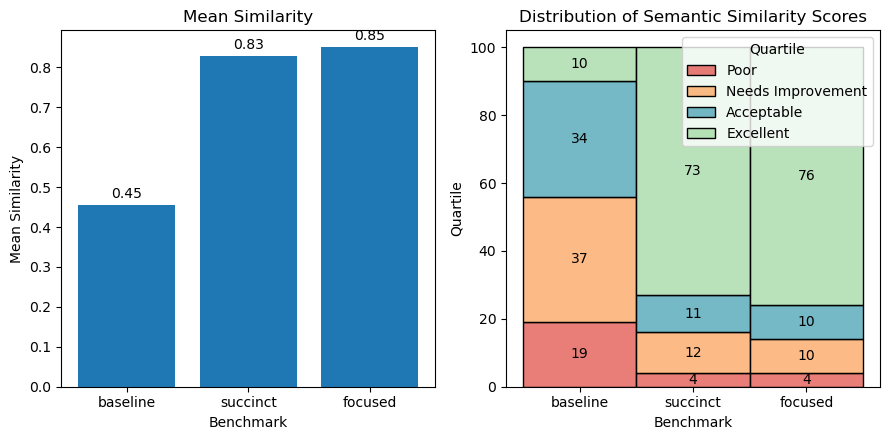

In [227]:
# Add mean similarity to each benchmark
for benchmark in benchmarks:
    benchmark["mean_similarity"] = benchmark["data"]["Similarity"].mean()

# Sort benchmarks by mean similarity
benchmarks.sort(key=lambda x: x["mean_similarity"], reverse=False)


# Plot the mean similarity for each benchmark
mean_similarities = [benchmark["mean_similarity"] for benchmark in benchmarks]

fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))
axs[0].bar(benchmark_names, mean_similarities)
for i, v in enumerate(mean_similarities):
    axs[0].text(i, v + 0.01, str(round(v, 2)), ha="center", va="bottom")
axs[0].set_xlabel("Benchmark")
axs[0].set_ylabel("Mean Similarity")
axs[0].set_title("Mean Similarity")

# Plot the distribution of semantic similarity scores across quartiles

# -- Create a dataframe with the quartile data for all benchmarks combined
quartiles = [0.25, 0.5, 0.75]
quartile_data = np.array([])
quartile_names = np.array([])
for benchmark in benchmarks:
    df = benchmark["data"]
    semscores = np.array(df["Similarity"].values)
    quartile_data = np.append(quartile_data, np.digitize(semscores, quartiles))
    quartile_names = np.append(quartile_names, [benchmark["name"]] * len(semscores))

df = pd.DataFrame({"name": quartile_names, "quartile": quartile_data})

# -- Plot the distribution of semantic similarity scores across quartiles
hue_order = list(df["quartile"].unique()) # Best performers on top
hue_order.sort(reverse=True)
ax = sns.histplot(
    df,
    x="name",
    hue="quartile",
    multiple="stack",
    hue_order=hue_order,
    palette=["#a2d9a4", "#47a0b3", "#fca55d", "#e2514a"],
)
ax.set_xlabel("Benchmark")
ax.set_ylabel("Quartile")
ax.set_title("Distribution of Semantic Similarity Scores")
ax.legend(
    title="Quartile", labels=["Poor", "Needs Improvement", "Acceptable", "Excellent"]
)

# -- Add the counts to the bars for easy reference
for container in ax.containers:
    labels = [
        f"{round(v.get_height())}" if v.get_height() > 0 else "" for v in container
    ]
    ax.bar_label(container, labels=labels, label_type="center")

plt.tight_layout()
plt.show()

#### Observations

* The `succinct` agent represents a significant improvement over the baseline, with a mean similarity of `0.83` and a distribution of semantic similarity scores across quartiles that is much closer to the top performer.
* However, the `focused` agent out-performs the `succinct` agent, with a mean similarity of `0.85`, with a handful of better answers.
* The performance is close enough that it may be worth while to look at the number of answers that would be considered correct across a range of possible thresholds. 

#### Number of answers with a semantic similarity score >= a given threshold

* Note: that I show every possible threshold starting at 0.01, but in practice it's unlikely that a threshold of 0.01 would be used as a threshold for acceptable answers.

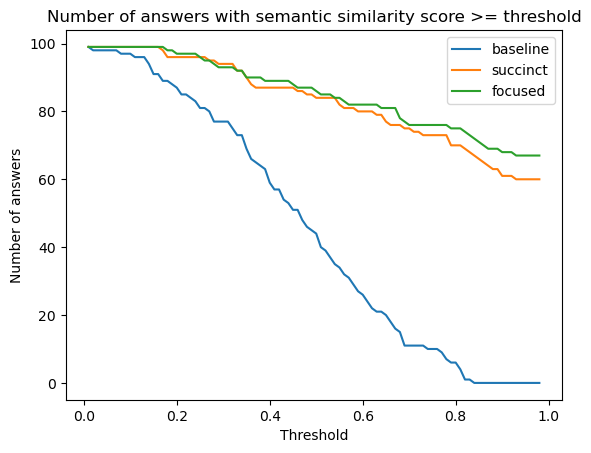

In [208]:
# Plot the number of answers with a semantic similarity score >= a given threshold for each benchmark
for benchmark in benchmarks:
    thresholds = np.arange(0.01, 0.99, 0.01)
    num_rows_above_threshold = []
    for threshold in thresholds:
        num_rows_above_threshold.append(len(benchmark['data'][benchmark['data']['Similarity'] >= threshold]))
    benchmark['num_rows_above_threshold'] = num_rows_above_threshold

for benchmark in benchmarks:
    plt.plot(thresholds, benchmark['num_rows_above_threshold'], label=benchmark['name'])
plt.xlabel('Threshold')
plt.ylabel('Number of answers')
plt.title('Number of answers with semantic similarity score >= threshold')
plt.legend()
plt.show()


#### Observations

* The `focused` agent outperforms the `succinct` agent by a small margin across most thresholds, until about 0.7, where it clearly outperforms the `succinct` agent.
* Given this, I will deliver the `focused` agent as the best performing agent.

#### Exactly correct answers

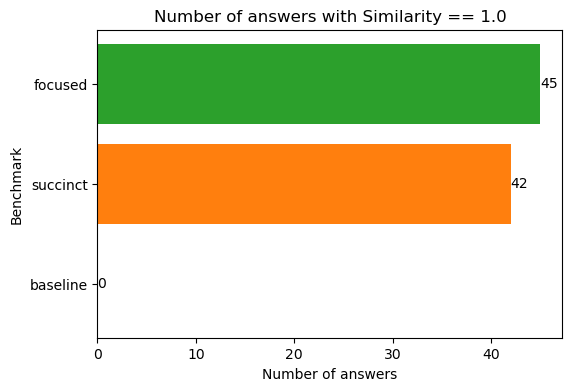

In [224]:
# Show how many answers have Similarity == 1.0 exactly
# Plot the number of answers with Similarity == 1.0 for each benchmark on a horizontal bar chart with seaborn
fig, ax = plt.subplots(figsize=(6, 4))
for benchmark in benchmarks:
    ax.barh(benchmark['name'], benchmark['data'][benchmark['data']['Similarity'] == 1.0].shape[0])
ax.set_xlabel('Number of answers')
ax.set_ylabel('Benchmark')
ax.set_title('Number of answers with Similarity == 1.0')
for container in ax.containers:
    ax.bar_label(container, label_type='edge')
plt.show()

#### Observations

* It's impressive that the `focused` and `succinct` agents both got nearly 50% of the answers exactly correct.

In [214]:
# Show the worst 10 answers for each benchmark
for benchmark in benchmarks:
    display(Markdown(f"#### Worse scoring answers for {benchmark['name']}"))
    display_text_df(
        benchmark["data"][
            ["Synthesized Question", "Answer", "Predicted Answer", "Similarity"]
        ]
        .sort_values(by="Similarity", ascending=True)
        .head(10)
    )

#### Worse scoring answers for baseline

#### Worse scoring answers for succinct

#### Worse scoring answers for focused

#### Observations

* All of the agents are unfairly penalized for elaborating on answers when the reference answer is brief. 
  * For example, in the worst-ranking answer when all 3 agents are correct (id=31138), but ranked the worst in semantic similarity due to the extra context they provided.
* Of the `baseline` agent's worst answers by semantic similarity, 3 are unquestionably incorrect, while the rest look correct from a human evaluator's perspective.
* Of the `succinct` agent's worst answers by semantic similarity, 2 are unquestionably incorrect, while the rest look correct from a human evaluator's perspective.
* Of the `focused` agent's worst answers by semantic similarity, 2 are unquestionably incorrect, while the rest look correct from a human evaluator's perspective.

In [215]:
# Show the best 10 answers for each benchmark
for benchmark in benchmarks:
    display(Markdown(f"#### Best scoring answers for {benchmark['name']}"))
    display_text_df(benchmark['data'][['Synthesized Question', 'Answer', 'Predicted Answer', 'Similarity']].sort_values(by='Similarity', ascending=False).head(10))

#### Best scoring answers for baseline

#### Best scoring answers for succinct

#### Best scoring answers for focused

#### Observations

* Here we can see `focused` and `succeinct` agents are producing exactly correct answers, while even at its best, the `baseline` agent is producing factually relevant and correct answers, but being penalized for elaborating and providing more context. 

## Conclusion

Overall, the semantic similarity metric differentiates between good and bad answers, but is prone to penalizing agents for elaborating on answers when the reference answer is brief.  

## Future Work

* It may be interesting to have human-generated, contextualized acceptable answers to go with the concise answers, and then take the max sementic similarity score between the predicted answer and the acceptable answers, to avoid penalizing agents for providing relevant context.
* It would also be interesting to look for and include the other acceptable answers found in the SQuAD dataset. 